# Machine Learning Homework 4 (deadline: November 11th, 10:15) 
## Evaluation measures and logistic regression

#### General instructions

Please look up the general instructions about homeworks from the first homework.

#### Tracking your time

We will appreciate if you track your time spent on solving the homework and report it in the dedicated cells at the end of the homework. This is not compulsory and does not affect your grade in any way. The collected information will be used to improve future homeworks.


## Task 1: Evaluation measures (2 points)

This task is built around the banknote authentication dataset. These data were extracted from images that were taken for the evaluation of an authentication procedure for banknotes. Original dataset has 5 features but we have decided to keep only 2, in order to make the classification task harder. There are two classes in this task: forged (1) and genuine (0). See more details about the data at https://archive.ics.uci.edu/ml/datasets/banknote+authentication .

In [2]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, \
                            f1_score, roc_curve, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from IPython.display import display
%matplotlib inline
np.random.seed(0)
CRED = '\033[91m'
CEND = '\033[0m'

In [3]:
df = pd.read_csv('data_banknote_authentication.txt', header = None, names=['variance','skewness','curtosis','entropy','y'])
df = df.drop(columns=['skewness','variance']) # We'll remove these two columns to make the task harder
pd.set_option('max_rows', 10)
display(df)

,curtosis,entropy,y
0,-2.8073,-0.44699,0
1,-2.4586,-1.46210,0
2,1.9242,0.10645,0
3,-4.0112,-3.59440,0
4,4.5718,-0.98880,0
...,...,...,...
1367,-1.4501,-0.55949,1
1368,6.4774,0.34179,1
1369,17.5932,-2.77710,1
1370,12.3930,-1.28230,1


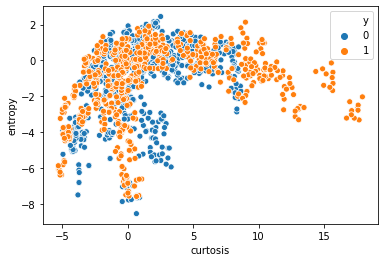

In [4]:
sns.scatterplot(df['curtosis'],df['entropy'],hue=df['y'])
plt.show()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('y', axis=1), df.y, 
                                                    train_size=0.7, test_size=0.3, 
                                                    random_state=0, shuffle=True, stratify=df.y)
X_train.shape, X_test.shape

((960, 2), (412, 2))

Now we will train and evaluate several classifiers. We will tune them as well in order to find optimal parameters and achieve  the best possible performance.

Every `sklearn` classifier has a set of tuneable parameters, you can check the list of defaults parameters like that:

In [6]:
knn = KNeighborsClassifier()
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

For the parameter tuning you can use Grid Search (check every possible combination of parameters from the predefined dictionary). Let us see what parameter values it found as best:

In [11]:
knn_param_grid = {
    'weights':['uniform', 'distance'],
    'n_neighbors': [1, 3, 5, 10, 15, 20, 30, 100]
}

knn_grid_search = GridSearchCV(knn, knn_param_grid, cv=3, return_train_score=True)
knn_grid_search.fit(X_train, y_train)
knn_grid_search.best_params_

{'n_neighbors': 1, 'weights': 'uniform'}

- **(a)** On the test set calculate the accuracy of the KNN model with default parameters and with the parameters selected by cross-validation. Which is better and why?

In [13]:
knn_default = KNeighborsClassifier()
try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    #raise NotImplementedError("You need to remove \"raise NotImplementedErrors\" lines after writing your code!")
    
    knn_default_mod = knn_default.fit(X_train,y_train)
    knn_default_test_accuracy = accuracy_score(y_test,knn_default_mod.predict(X_test))
    
    knn_grid_search_clf = KNeighborsClassifier(n_neighbors= 1, weights= 'uniform')
    knn_grid_search_mod = knn_grid_search.fit(X_train,y_train)
    knn_tuned_test_accuracy=accuracy_score(y_test, knn_grid_search_mod.predict(X_test))
    
    print('KNN test accuracy with default parameters:',knn_default_test_accuracy)
    print('KNN test accuracy after parameter tuning :',knn_tuned_test_accuracy)
    
    ##### YOUR CODE ENDS ##### (please do not delete this line)

except NotImplementedError as e:
    print(CRED,"TODO:",e,CEND)
except Exception as e:
    print("Exception:", e)

KNN test accuracy with default parameters: 0.7257281553398058
KNN test accuracy after parameter tuning : 0.6820388349514563


**<font color='purple'>Answer to (a):</font>** the best parameters chosen from the grid search does not guarantee a higher accuracy as other parameters were not included. the default classifier had more parameters.

- **(b)** Look at the detailed results of cross-validation as printed below. The columns ending with '_time' are about running time, but please describe the meaning of other columns.

In [17]:
knn_cv_results = pd.DataFrame(knn_grid_search.cv_results_)
knn_cv_results.head(10)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.002999,8.166321e-04,0.015324,3.089388e-03,1,uniform,"{'n_neighbors': 1, 'weights': 'uniform'}",0.704050,0.731250,0.699060,0.711458,0.014142,1,1.000000,1.000000,1.000000,1.000000,0.000000
1,0.002664,9.414482e-04,0.001999,5.947204e-07,1,distance,"{'n_neighbors': 1, 'weights': 'distance'}",0.704050,0.731250,0.699060,0.711458,0.014142,1,1.000000,1.000000,1.000000,1.000000,0.000000
2,0.003995,1.629176e-03,0.015989,3.555508e-03,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.704050,0.681250,0.699060,0.694792,0.009790,8,0.866980,0.853125,0.861154,0.860420,0.005680
3,0.001999,5.840039e-07,0.003334,4.738992e-04,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",0.669782,0.684375,0.705329,0.686458,0.014587,12,1.000000,1.000000,1.000000,1.000000,0.000000
4,0.002333,4.709208e-04,0.013338,1.253914e-03,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",0.685358,0.653125,0.686520,0.675000,0.015475,14,0.813772,0.796875,0.811232,0.807293,0.007439
5,0.002999,8.152719e-04,0.002337,4.789569e-04,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.679128,0.696875,0.689655,0.688542,0.007293,9,1.000000,1.000000,1.000000,1.000000,0.000000
6,0.002991,8.174554e-04,0.013313,1.239343e-03,10,uniform,"{'n_neighbors': 10, 'weights': 'uniform'}",0.688474,0.684375,0.692790,0.688542,0.003433,9,0.762128,0.765625,0.764431,0.764061,0.001451
7,0.002332,4.711456e-04,0.003325,4.616485e-04,10,distance,"{'n_neighbors': 10, 'weights': 'distance'}",0.704050,0.709375,0.699060,0.704167,0.004209,4,1.000000,1.000000,1.000000,1.000000,0.000000
8,0.001999,4.495664e-07,0.017643,5.243261e-03,15,uniform,"{'n_neighbors': 15, 'weights': 'uniform'}",0.716511,0.696875,0.652038,0.688542,0.026973,9,0.732394,0.721875,0.756630,0.736967,0.014552
9,0.002998,7.018853e-07,0.002999,6.836514e-07,15,distance,"{'n_neighbors': 15, 'weights': 'distance'}",0.722741,0.718750,0.667712,0.703125,0.025036,5,1.000000,1.000000,1.000000,1.000000,0.000000


**<font color='purple'>Answer to (b):</font>**
param_n_neighbors - Specify the various options for number of neighbors
param_weights -      Specify the various options for weighting option.
params - the combination of parameter values from the listed options
split0_test_score - the validation score on the 1st split
split1_test_score - the validation score on the 2nd split
split2_test_score- the validation score on the 3rd split
mean_test_score - the mean score for all test splits given a combination of parameters.
std_test_score  - the standard deviation of the various validation scores from the  mean score for the given combination of parameters.
rank_test_score - rating of the parameter combinations based on their mean_test_score(s)q
split0_train_score - the training score (accuracy) for the first split - fold
split1_train_score - the training score  for the 2nd split - fold
split2_train_score-  the training score  for the 3rd split - fold
mean_train_score - the mean score for the for all the trianing for all the splits
std_train_score - the standard deviation of the training scores from the splits for a given combinatio of parameters.

<font color='purple'>Note that the column names involving the word 'test' might be a bit confusing - they are referring to the test fold within cross-validation, which perhaps could be better called a validation fold. Therefore, the accuracies in this table are also potentially different from what you found in subtask (b).</font>

Let us now keep only some of the columns which are the most relevant for our purpose. Also, let us sort the results by mean_test_score.

In [25]:
def cv_column_filter(df):
    return(df.loc[:,[c for c in df.columns 
                     if (c[:11]=='mean_train_') or 
                        (c[:10]=='mean_test_') or 
                        (c[:6]=='param_')]])

knn_cv_results = cv_column_filter(knn_cv_results)
knn_cv_results = knn_cv_results.sort_values('mean_test_score',ascending=False)
pd.set_option('max_rows', 20)
knn_cv_results.sort_values(by=['param_n_neighbors'],ascending=True)

,param_n_neighbors,param_weights,mean_test_score,mean_train_score
0,1,uniform,0.711458,1.000000
1,1,distance,0.711458,1.000000
2,3,uniform,0.694792,0.860420
3,3,distance,0.686458,1.000000
5,5,distance,0.688542,1.000000
4,5,uniform,0.675000,0.807293
7,10,distance,0.704167,1.000000
6,10,uniform,0.688542,0.764061
9,15,distance,0.703125,1.000000
8,15,uniform,0.688542,0.736967


- **(c)** Looking at the above table, are both parameters important factors for the performance of KNN? Generally, is more or less neighbours good in this task? Is uniform or distance-based weighting better in this task?

**<font color='purple'>Answer to (c):</font>** When the number of neighbours is one, the distance does not influence the score based on this table. The score starts to vary based on the weighting parameter when the number of neighbours increases. Generally as the number of neighbours increase the distance weighting returns higher scores. The safest option or 'best' is one neighbour with any weighting parameter.

- **(d)** Let us now wrap up parameter tuning process into a single function, which would later work for other types of models as well, not just KNN models. Compare the displayed table to knn_cv_results above and explain the meaning of extra columns.

In [26]:
def tune_model(model, param_grid, X_train=X_train, y_train=y_train, cv=5, max_rows=10):
    grid_search = GridSearchCV(model, param_grid, cv=cv, return_train_score=True, scoring=['accuracy','f1','roc_auc'],refit='accuracy')
    grid_search.fit(X_train, y_train)
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results = cv_column_filter(cv_results)
    cv_results = cv_results.sort_values('mean_test_accuracy',ascending=False)
    pd.set_option('max_rows',max_rows)
    display(cv_results)
    pd.reset_option('max_rows')
    return(grid_search)

In [27]:
knn = KNeighborsClassifier()
knn_param_grid = {
    'weights':['uniform', 'distance'],
    'n_neighbors': [1, 3, 5, 10, 15, 20, 30, 100]
}
knn_tuned = tune_model(knn, knn_param_grid, cv=3, max_rows=20)
print(knn_tuned.best_params_)
print(knn_tuned.best_score_)

,param_n_neighbors,param_weights,mean_test_accuracy,mean_train_accuracy,mean_test_f1,mean_train_f1,mean_test_roc_auc,mean_train_roc_auc
0,1,uniform,0.711458,1.000000,0.678228,1.000000,0.708682,1.000000
1,1,distance,0.711458,1.000000,0.678228,1.000000,0.708682,1.000000
11,20,distance,0.709375,1.000000,0.647773,1.000000,0.776864,1.000000
7,10,distance,0.704167,1.000000,0.651873,1.000000,0.784004,1.000000
9,15,distance,0.703125,1.000000,0.644133,1.000000,0.778085,1.000000
13,30,distance,0.703125,1.000000,0.625021,1.000000,0.775788,1.000000
15,100,distance,0.703125,1.000000,0.583758,1.000000,0.757162,1.000000
2,3,uniform,0.694792,0.860420,0.646387,0.841092,0.741453,0.933636
5,5,distance,0.688542,1.000000,0.639328,1.000000,0.775684,1.000000
6,10,uniform,0.688542,0.764061,0.590884,0.693509,0.751756,0.844851


{'n_neighbors': 1, 'weights': 'uniform'}
0.7114583333333333


**<font color='purple'>Answer to (d):</font>** 
mean_test_f1- it is the mean f1 score on validation set of the combination of parameters after various splits.  
mean_train_f1- it is the mean f1 score on training set of the combination of parameters after various splits.
mean_test_roc_auc- it is the probability that an instance will be classified correctly given the mean threshold from the various validation sets  for each parameter combination
mean_train_roc_auc- it is the probability that an instance will be classified correctly given the mean threshold from the various training sets  for each parameter combination
f1- is a measure of how well the model is likely to be correct or not make a mistake (predicting false positives and false negatives)

- **(e)** Are different parameter settings ranked similarly according to different evaluation measures? What are the similarities and differences between measures, according to which parameter settings they consider better or worse?

**<font color='purple'>Answer to (e):</font>**

- **(f)** Tune the Decision Tree learner by trying out 20-100 different combinations of at least 2 parameters. Report the best hyperparameter values and the cross-validated accuracy estimate. Hint: see how the same was done above using knn_tuned object.

In [29]:
dt = DecisionTreeClassifier()
try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    #raise NotImplementedError("You need to remove \"raise NotImplementedErrors\" lines after writing your code!")
    
    dt_grid = {'criterion':['gini', 'entropy'],
    'max_depth': [5, 15, 10,20, 25,30], 'max_features':['auto','sqrt','log2'] }
    dt_tuned = tune_model(dt, dt_grid)
    
    print('Best hyperparameter values:',dt_tuned.best_params_)
    print('Cross-validated accuracy estimate for these parameter values:',dt_tuned.best_score_)
    ##### YOUR CODE ENDS ##### (please do not delete this line)
    
except NotImplementedError as e:
    print(CRED,"TODO:",e,CEND)
except Exception as e:
    print("Exception:", e)

C:\Users\isaac90\.conda\envs\datascienceml-environment\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,param_criterion,param_max_depth,param_max_features,mean_test_accuracy,mean_train_accuracy,mean_test_f1,mean_train_f1,mean_test_roc_auc,mean_train_roc_auc
23,entropy,15,log2,0.682292,0.891689,0.619952,0.869568,0.691721,0.964628
30,entropy,25,auto,0.675000,0.982556,0.627580,0.979553,0.672823,0.998157
22,entropy,15,sqrt,0.671875,0.879135,0.600094,0.854500,0.679148,0.951211
25,entropy,10,sqrt,0.669792,0.777359,0.547365,0.697567,0.694723,0.863590
29,entropy,20,log2,0.667708,0.932553,0.600185,0.918203,0.663562,0.984804
...,...,...,...,...,...,...,...,...,...
20,entropy,5,log2,0.631250,0.660152,0.388210,0.440790,0.628496,0.680448
1,gini,5,sqrt,0.629167,0.661454,0.362344,0.406619,0.620925,0.676633
2,gini,5,log2,0.627083,0.663538,0.340910,0.403045,0.615960,0.685808
0,gini,5,auto,0.623958,0.657308,0.350744,0.410360,0.626300,0.688266


Best hyperparameter values: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'log2'}
Cross-validated accuracy estimate for these parameter values: 0.6822916666666666


- **(g)** Tune the Random Forest learner by trying out 20-100 different combinations of at least 2 parameters. Report the best hyperparameter values and the cross-validated accuracy estimate. Compare columns of mean_train_accuracy and mean_test_accuracy and report which parameter values lead to more overfitting or less overfitting (or whether there is any overfitting at all).

In [30]:
rf = RandomForestClassifier()
try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    #raise NotImplementedError("You need to remove \"raise NotImplementedErrors\" lines after writing your code!")
    
    rf_grid = {'criterion':['gini', 'entropy'],
    'max_depth': [5, 15, 10,20, 25,30], 'max_features':['auto','sqrt','log2'] }
    rf_tuned = tune_model(rf, rf_grid)
    
    print('Best hyperparameter values:',rf_tuned.best_params_)
    print('Cross-validated accuracy estimate for these parameter values:',rf_tuned.best_score_)
    ##### YOUR CODE ENDS ##### (please do not delete this line)
    
except NotImplementedError as e:
    print(CRED,"TODO:",e,CEND)
except Exception as e:
    print("Exception:", e)

C:\Users\isaac90\.conda\envs\datascienceml-environment\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,param_criterion,param_max_depth,param_max_features,mean_test_accuracy,mean_train_accuracy,mean_test_f1,mean_train_f1,mean_test_roc_auc,mean_train_roc_auc
7,gini,10,sqrt,0.697917,0.879161,0.618527,0.850655,0.750098,0.961968
28,entropy,20,sqrt,0.695833,0.968226,0.634225,0.963427,0.744001,0.996819
6,gini,10,auto,0.695833,0.876037,0.613580,0.847082,0.749988,0.961370
13,gini,25,sqrt,0.694792,0.980985,0.619107,0.978201,0.744110,0.998749
34,entropy,30,sqrt,0.693750,0.977339,0.626305,0.974096,0.741421,0.997881
...,...,...,...,...,...,...,...,...,...
2,gini,5,log2,0.660417,0.708592,0.457592,0.534749,0.708098,0.815215
18,entropy,5,auto,0.658333,0.696610,0.446063,0.500689,0.697583,0.805245
0,gini,5,auto,0.655208,0.714069,0.449328,0.550715,0.695507,0.823985
1,gini,5,sqrt,0.652083,0.709383,0.456124,0.544361,0.707457,0.829983


Best hyperparameter values: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt'}
Cross-validated accuracy estimate for these parameter values: 0.6979166666666666


**<font color='purple'>Answer to (g):</font>**

- **(h)** Tune the SVM-RBF learner by trying out 20-100 different combinations of at least 2 parameters. Report the best hyperparameter values and the cross-validated accuracy estimate. 

In [32]:
try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    #raise NotImplementedError("You need to remove \"raise NotImplementedErrors\" lines after writing your code!")
    
    svm = SVC(kernel='rbf', probability=True)
    svm_grid = {'C':[0.2,0.4,0.6],'degree':[2,3,4],'gamma':[0.1,0.6,0.9]}
    svm_tuned = tune_model(svm, svm_grid)
    
    print('Best hyperparameter values:',svm_tuned.best_params_)
    print('Cross-validated accuracy estimate for these parameter values:',svm_tuned.best_score_)
    ##### YOUR CODE ENDS ##### (please do not delete this line)
    
except NotImplementedError as e:
    print(CRED,"TODO:",e,CEND)
except Exception as e:
    print("Exception:", e)

C:\Users\isaac90\.conda\envs\datascienceml-environment\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,param_C,param_degree,param_gamma,mean_test_accuracy,mean_train_accuracy,mean_test_f1,mean_train_f1,mean_test_roc_auc,mean_train_roc_auc
26,0.6,4,0.9,0.715625,0.753652,0.613538,0.667646,0.754919,0.818144
23,0.6,3,0.9,0.715625,0.753652,0.613538,0.667646,0.754919,0.818144
20,0.6,2,0.9,0.715625,0.753652,0.613538,0.667646,0.754919,0.818144
14,0.4,3,0.9,0.710417,0.751570,0.603310,0.661974,0.749140,0.808362
17,0.4,4,0.9,0.710417,0.751570,0.603310,0.661974,0.749140,0.808362
...,...,...,...,...,...,...,...,...,...
12,0.4,3,0.1,0.638542,0.649991,0.415590,0.441221,0.678274,0.692717
9,0.4,2,0.1,0.638542,0.649991,0.415590,0.441221,0.678274,0.692717
6,0.2,4,0.1,0.622917,0.631243,0.367579,0.387531,0.668997,0.679678
3,0.2,3,0.1,0.622917,0.631243,0.367579,0.387531,0.668997,0.679678


Best hyperparameter values: {'C': 0.6, 'degree': 2, 'gamma': 0.9}
Cross-validated accuracy estimate for these parameter values: 0.715625


- **(i)** All the above models can produce class probabities. For example, with the decision tree the probabilities for the first 5 training instances are as follows. What would the predicted classes on these 5 instances be, if we thresholded the model at probability 0.5?

In [33]:
pd.DataFrame(rf_tuned.predict_proba(X_train)[:5,:],columns=rf_tuned.classes_)

,0,1
0,0.246481,0.753519
1,0.250000,0.750000
2,0.552538,0.447462
3,0.112500,0.887500
4,0.709416,0.290584


**<font color='purple'>Answer to (i):</font>** 1 1 0 1 0

- **(j)** Next we define a new class ThresholdedModel which can be constructed from any classifier which can produce class probabilities using predict_proba function. Construct a ThresholdedModel on rf_tuned with threshold 0.5. Report what the predicted classes are for the first 5 training instances. Also report the overall accuracy and F1-measure on the training set.

In [53]:
class ThresholdedModel:
    def __init__(self,model,threshold):
        self.model = model
        self.threshold = threshold
    def __str__(self):
        return('%s thresholded at %f' % (str(self.model.estimator).split('(')[0], self.threshold))
    def predict(self,X):
        return(np.array(self.model.predict_proba(X)[:,1] >= self.threshold, dtype=int))

In [54]:
try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    #raise NotImplementedError("You need to remove \"raise NotImplementedErrors\" lines after writing your code!")

    rf_thr05 = ThresholdedModel(rf_tuned,0.5)
    rf_thr05_predictions = rf_thr05.predict(X_train)
    print('Predicted classes of first 5 instances are:',rf_thr05_predictions[:5] )
    print('Training set accuracy:',accuracy_score(y_train,rf_thr05_predictions))
    print('Training set F-measure:',f1_score(y_train,rf_thr05_predictions))
    
except NotImplementedError as e:
    print(CRED,"TODO:",e,CEND)
except Exception as e:
    print("Exception:", e)

Predicted classes of first 5 instances are: [1 1 0 1 0]
Training set accuracy: 0.8239583333333333
Training set F-measure: 0.7830551989730424


- **(k)** Next we define a function to consider all possible thresholds and find the one which maximizes the F-measure on the training data. Please explain what each of the 4 rows is doing in the function.

In [45]:
def optimize_threshold(model, measure_func, X, y):
    predictions = model.predict_proba(X)[:,1]    ### ROW 1
    thresholds = sorted(np.unique(list(predictions)+[np.inf]))     ### ROW 2
    scores = [measure_func(y,np.array(predictions>=t, dtype=int)) for t in thresholds]    ### ROW 3
    return(ThresholdedModel(model,thresholds[np.argmax(scores)]))   ### ROW 4


dt_opt_f1 = optimize_threshold(dt_tuned,f1_score,X_train,y_train)
dt_opt_acc = optimize_threshold(dt_tuned,accuracy_score,X_train,y_train)
rf_opt_f1 = optimize_threshold(rf_tuned,f1_score,X_train,y_train)
rf_opt_acc = optimize_threshold(rf_tuned,accuracy_score,X_train,y_train)
svm_opt_f1 = optimize_threshold(svm_tuned,f1_score,X_train,y_train)
svm_opt_acc = optimize_threshold(svm_tuned,accuracy_score,X_train,y_train)
print(dt_opt_f1)
print(dt_opt_acc)
print(rf_opt_f1)
print(rf_opt_acc)
print(svm_opt_f1)
print(svm_opt_acc)

DecisionTreeClassifier thresholded at 0.500000
DecisionTreeClassifier thresholded at 0.500000
RandomForestClassifier thresholded at 0.404252
RandomForestClassifier thresholded at 0.404252
SVC thresholded at 0.259062
SVC thresholded at 0.542054


**<font color='purple'>Answer to (k):</font>**row 1 assigns the probabilities for the class 1 to the variable preditions. predict_proba method 
provides the class probalities for each instance.

row 2 passes unique probabilities as thresholds for the classifier.

row 3 finds the f1_score or accuracy_score for each of the thresholds.

row 4 returns the maximum or highest f1_score or accuracy_score for the model.


- **(l)** Run the code below to evaluate the constructed models with several measures. Judging by accuracy, which of the models are less affected by overfitting, which more affected?

In [50]:
from sklearn.metrics import SCORERS,make_scorer

def evaluate_models(models,measures,X,y):
    return(pd.concat( [pd.DataFrame({'model':[str(model) for model in models]}),
        pd.DataFrame({measure:[SCORERS[measure](model,X,y) for model in models] for measure in measures}) ],axis=1))

models = [dt_tuned,dt_opt_acc,dt_opt_f1,
          rf_tuned,rf_opt_acc,rf_opt_f1,
          svm_tuned,svm_opt_acc,svm_opt_f1]
measures = ['accuracy','precision','recall','f1']
display(evaluate_models(models,measures,X_train,y_train))
display(evaluate_models(models,measures,X_test,y_test))

,model,accuracy,precision,recall,f1
0,"GridSearchCV(cv=5, error_score='raise-deprecat...",0.888542,0.923280,0.817330,0.867081
1,DecisionTreeClassifier thresholded at 0.500000,0.888542,0.904040,0.838407,0.869988
2,DecisionTreeClassifier thresholded at 0.500000,0.888542,0.904040,0.838407,0.869988
3,"GridSearchCV(cv=5, error_score='raise-deprecat...",0.823958,0.866477,0.714286,0.783055
4,RandomForestClassifier thresholded at 0.404252,0.848958,0.801282,0.878220,0.837989
5,RandomForestClassifier thresholded at 0.404252,0.848958,0.801282,0.878220,0.837989
6,"GridSearchCV(cv=5, error_score='raise-deprecat...",0.756250,0.845878,0.552693,0.668555
7,SVC thresholded at 0.542054,0.760417,0.845614,0.564403,0.676966
8,SVC thresholded at 0.259062,0.671875,0.582111,0.929742,0.715960


,model,accuracy,precision,recall,f1
0,"GridSearchCV(cv=5, error_score='raise-deprecat...",0.711165,0.686047,0.644809,0.664789
1,DecisionTreeClassifier thresholded at 0.500000,0.689320,0.648649,0.655738,0.652174
2,DecisionTreeClassifier thresholded at 0.500000,0.689320,0.648649,0.655738,0.652174
3,"GridSearchCV(cv=5, error_score='raise-deprecat...",0.711165,0.686047,0.644809,0.664789
4,RandomForestClassifier thresholded at 0.404252,0.684466,0.616740,0.765027,0.682927
5,RandomForestClassifier thresholded at 0.404252,0.684466,0.616740,0.765027,0.682927
6,"GridSearchCV(cv=5, error_score='raise-deprecat...",0.728155,0.744828,0.590164,0.658537
7,SVC thresholded at 0.542054,0.730583,0.740000,0.606557,0.666667
8,SVC thresholded at 0.259062,0.614078,0.538217,0.923497,0.680080


**<font color='purple'>Answer to (l):</font>** the support vector models are less affected by overfitting. the Random forest and Decision trees are more affected by overfitting although their tuned models are fairly okay.

- **(m)** From the above tables compare the F-measure performance of the cross-validated model using default threshold (*_tuned) with the threshold specifically optimised for F-measure. Was there any benefit from threshold optimisation?

**<font color='purple'>Answer to (m):</font>**  The oprtimized models performed slightly better than the tuned approximately >=0.04 in the cases of the SVM and Random forest for the training set. The same cannot be said for the test data. O the test data the opt models for RF and SVM did slightly better than the tuned model but not with a difference as high as on the training data.

- **(n)** From the above tables compare the accuracy performance of the cross-validated model using default threshold (*_tuned) with the threshold specifically optimised for accuracy. Was there any benefit from threshold optimisation?

**<font color='purple'>Answer to (n):</font>**The oprtimized models performed slightly better than the tuned approximately >=0.02 in the cases of the SVM and Random forest. The optmized DT was as good as the tuned for the training set. The same cannot be said for the test data.On the test data the tuned models performed better than the optimized models.

- **(o)** Compare the confusion matrices on the test data for two of the models from subtask (l). Choose one which has high F-measure and one which has high accuracy. What are the key differences between these confusion matrices?

In [58]:
try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    #raise NotImplementedError("You need to remove \"raise NotImplementedErrors\" lines after writing your code!")
    svc05 = ThresholdedModel(svm_tuned,0.542054)
    rf04 = ThresholdedModel(rf_tuned,0.404252)
    
    print(confusion_matrix(y_test,svc05.predict(X_test)))
    print(confusion_matrix(y_test,rf04.predict(X_test)))
    ##### YOUR CODE ENDS ##### (please do not delete this line)

except NotImplementedError as e:
    print(CRED,"TODO:",e,CEND)
except Exception as e:
    print("Exception:", e)

[[190  39]
 [ 72 111]]
[[142  87]
 [ 43 140]]


**<font color='purple'>Answer to (o):</font>**

- **(p)** Finally, draw the ROC curves for the scoring classifiers and add the thresholded models to the plot using our given code, on the training data. Is some model dominating over any other (higher everywhere)? What are the main differences between the ROC curves on train and test data?

In [47]:
def roc_plot(models, thresholded_models, X, y):
    fig = plt.figure(figsize=(8,8))
    for model in models:
        probs = model.predict_proba(X)[:,1]
        auc = roc_auc_score(y, probs)
        fpr,tpr,thr = roc_curve(y,probs)
        plt.plot(fpr, tpr, label='{} (AUC={:.2f})'.format(str(model.estimator).split('(')[0], auc))
    for t_model in thresholded_models:
        y_pred = t_model.predict(X)
        tpr = np.sum(np.logical_and(y_pred, y == 1)) / np.sum(y == 1)
        fpr = np.sum(np.logical_and(y_pred, y == 0)) / np.sum(y == 0)
        plt.plot(fpr, tpr, 'x', label='{}'.format(str(t_model)))
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.show()

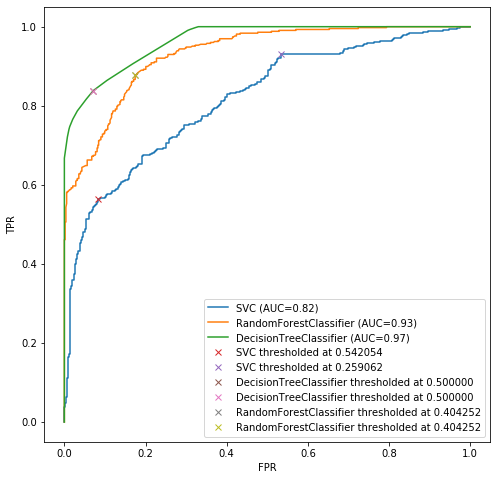

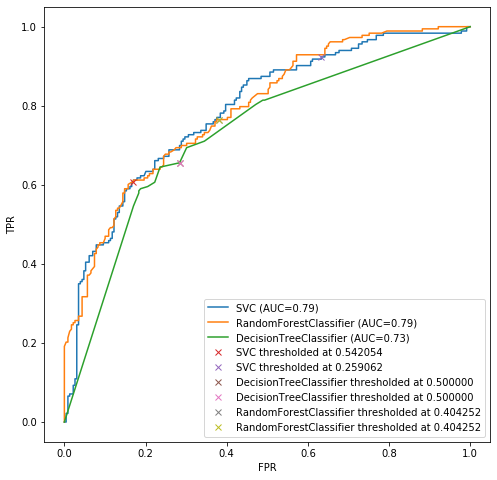

In [48]:
roc_plot([svm_tuned,rf_tuned,dt_tuned],[svm_opt_acc,svm_opt_f1,dt_opt_acc,dt_opt_f1,rf_opt_acc,rf_opt_f1],X_train,y_train)
roc_plot([svm_tuned,rf_tuned,dt_tuned],[svm_opt_acc,svm_opt_f1,dt_opt_acc,dt_opt_f1,rf_opt_acc,rf_opt_f1],X_test,y_test)

**<font color='purple'>Answer to (p):</font>** on the training data, the DT model is the best but the worst performer on the test data. the SVC and the RF have a similar accuracy on the test data. the ROC data shows that the DT is overfitted.

## Task 2: Logistic regression (4 points)

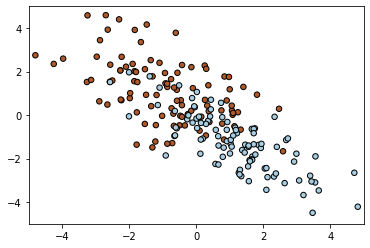

In [195]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def create_synthetic_data(n_instances):
    n_positives = round(n_instances/2)
    n_negatives = n_instances - n_positives
    X = np.zeros((n_instances,2))
    X[:n_positives,:] = np.random.multivariate_normal((-1,+1),((2,-1),(-1,2)),n_positives)
    X[n_positives:,:] = np.random.multivariate_normal((+1,-1),((2,-1.5),(-1.5,2)),n_negatives)
    Y = n_positives*[1]+n_negatives*[0]
    return(X,Y)

np.random.seed(0)
train_X, train_Y = create_synthetic_data(200)
test_X, test_Y = create_synthetic_data(20000)

plt.scatter(train_X[:, 0], train_X[:, 1], s=30, c=train_Y, cmap=plt.cm.Paired, edgecolors='k')
plt.axis([-5, 5, -5, 5])
plt.show()


#train_X.shape[1],1


- **(a)** Implement logistic regression using gradient descent of cross entropy. For this look up the formula for cross entropy and its gradient formulas from the lecture slides. Print out the final weights and bias term. Print out the number of iterations that the algorithm ran.  

**<font color='purple'>(a) Your implementation, prints out the final weights and bias term and the number of iterations:</font>**

In [200]:
try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    #raise NotImplementedError("You need to remove \"raise NotImplementedErrors\" lines after writing your code!")
    class LogisticRegression :
        def __init__(self,lr,X,y) :
            self.lr =lr
            self.X = X
            self.y = y
      
        
        def sigmoid (self,theta):
            return 1/(1+np.exp(-theta))
                      
        def loss (self,y_pred,y):
            return np.mean((-y * np.log(y_pred) -[1-t for t in y]* np.log(1-b for b in y_pred))) 
                      
        def fit (self,X,y):
            iterr =0
            iterr_list=[0]
            cross_list = [0]
            np.random.seed(0)
            self.W = np.zeros(X.shape[1])
            theta = np.dot(X,self.W)
            y_pred = self.sigmoid(theta)
            converged = False
            while not converged:
                cross_entropy = self.loss(y_pred,y)
                cross_list.append(cross_entropy)
                iterr +=1
                iterr_list.append(iterr)
                if cross_list[iterr] - cross_list[iterr-1] > 0.001:
                    self.W -=   self.lr*np.sum(np.dot(X,(y_pred-y)))
                    converged = False
            return (iterr_list,cross_list)
            print(W, iterr, b)
    ##### YOUR CODE ENDS ##### (please do not delete this line)
    
except NotImplementedError as e:
    print(CRED,"TODO:",e,CEND)
except Exception as e:
    print("Exception:", e)

- **(b)** Supplement each iteration of your above implementation with the calculation of cross entropy on the training data and on the test data. Make a plot with iteration number on the x-axis and cross entropy on the y-axis, with training and test loss shown in different colour. Discuss if you see signs of overfitting.

**<font color='purple'>(b) Your implementation making the plot:</font>**

In [201]:
try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    #raise NotImplementedError("You need to remove \"raise NotImplementedErrors\" lines after writing your code!")
    lr_test =LogisticRegression(lr=0.5,X=train_X,y=train_Y)
    lr_test = lr_test.fit(train_X,train_Y)
    
    ##### YOUR CODE ENDS ##### (please do not delete this line)
    
except NotImplementedError as e:
    print(CRED,"TODO:",e,CEND)
except Exception as e:
    print("Exception:", e)

Exception: bad operand type for unary -: 'list'


In [199]:

X = np.array(train_X)
target = train_Y 
W = [0,1,1]
theta = np.dot(train_X,W)
theta
sigs = 1/(1+np.exp(theta))
sigs
loss= -np.mean((target*np.log(sigs)+[1-t for t in target]*np.log(1-sigs)))
loss

ValueError: shapes (200,2) and (3,) not aligned: 2 (dim 1) != 3 (dim 0)

**<font color='purple'>Discuss if you see signs of overfitting:</font>**

- **(c)** Compare your learned weights and bias term to those obtained from sklearn implementation of logistic regression (sklearn.linear_model.LogisticRegression). Please use the parameter C value `C=1e10` (this is needed as by default sklearn logistic regression uses regularisation). Print out the final weights and bias term. Print out the differences from what your implementation found (subtract sklearn weights and bias from your weights and bias, respectively, and print out). The coefficients from sklearn implementation and your implementation must not differ by more than 0.001 (if they do then please check your code and possibly run more iterations or adjust the learning rate). 

**<font color='purple'>(c) Your code to print the model learned with sklearn implementation of logistic regression and its difference from yours:</font>**

In [ ]:
try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    raise NotImplementedError("You need to remove \"raise NotImplementedErrors\" lines after writing your code!")
    
    ...
    
    ##### YOUR CODE ENDS ##### (please do not delete this line)
    
except NotImplementedError as e:
    print(CRED,"TODO:",e,CEND)
except Exception as e:
    print("Exception:", e)

- **(d)** Implement logistic regression using **stochastic** gradient descent of cross entropy. Print out the final weights and bias term. Print out the differences in weights and bias between this implementation and sklearn logistic regression (sklearn.linear_model.LogisticRegression, same as in subtask (c)). The coefficients from sklearn implementation and your implementation must not differ by more than 0.001 (if they do then please check your code and possibly run more iterations or adjust the learning rate). 

**<font color='purple'>(d) Your implementation, prints out the final weights and bias term and the number of iterations, prints out the differences between your implementation and sklearn:</font>**

In [ ]:
try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    raise NotImplementedError("You need to remove \"raise NotImplementedErrors\" lines after writing your code!")
    
    ...
    
    ##### YOUR CODE ENDS ##### (please do not delete this line)
    
except NotImplementedError as e:
    print(CRED,"TODO:",e,CEND)
except Exception as e:
    print("Exception:", e)

- **(e)** About your stochastic gradient descent implementation make the same plot as you did in subtask **(b)** about gradient descent (cross entropy on train and test at each iteration). Discuss if you see signs of overfitting. Discuss the differences of plots about gradient descent and stochastic gradient descent.

**<font color='purple'>Your implementation making the plot:</font>**

In [ ]:
try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    raise NotImplementedError("You need to remove \"raise NotImplementedErrors\" lines after writing your code!")
    
    ...
    
    ##### YOUR CODE ENDS ##### (please do not delete this line)
    
except NotImplementedError as e:
    print(CRED,"TODO:",e,CEND)
except Exception as e:
    print("Exception:", e)

**<font color='purple'>Discuss if you see signs of overfitting:</font>**

**<font color='purple'>Discuss the differences of plots about gradient descent and stochastic gradient descent:</font>**

- **(f)** Calculate and report accuracy of the logistic regression model on the test data. Do this on the model learned with sklearn in subtask **(c)**. 

**<font color='purple'>(f) Your implementation reporting accuracy:</font>**

In [ ]:
try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    raise NotImplementedError("You need to remove \"raise NotImplementedErrors\" lines after writing your code!")
    
    ...
    
    ##### YOUR CODE ENDS ##### (please do not delete this line)
    
except NotImplementedError as e:
    print(CRED,"TODO:",e,CEND)
except Exception as e:
    print("Exception:", e)

- **(g)** Since we have generated the data ourselves with balanced classes drawn from two Gaussian distributions, we know what the optimal classifier is. The optimal classifier must predict positive whenever the likelihood of the positive class is higher than the likelihood of the negative class (as the class priors are equal, comparing the likelihoods is sufficient). For each test instance calculate these likelihoods and then calculate the accuracy of the optimal classifier on the test data (this classifier is known as the Bayes-optimal classifier). 

**<font color='purple'>(g) Add to the following implementation and print accuracy of the Bayes-optimal classifier:</font>**

In [ ]:
from scipy.stats import multivariate_normal


try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    raise NotImplementedError("You need to remove \"raise NotImplementedErrors\" lines after writing your code!")
    
    pos_likelihood_func = multivariate_normal(mean=(-1,+1), cov=((2,-1),(-1,2))).pdf
    neg_likelihood_func = multivariate_normal(mean=(+1,-1), cov=((2,-1.5),(-1.5,2))).pdf

    # Example usage:
    # print(pos_likelihood_func(test_X))
    # print(neg_likelihood_func(test_X))
    
    ##### YOUR CODE ENDS ##### (please do not delete this line)
    
except NotImplementedError as e:
    print(CRED,"TODO:",e,CEND)
except Exception as e:
    print("Exception:", e)

- **(h)** Learn a SVM model with RBF kernel with default parameters and report the accuracy on the test data.

**<font color='purple'>(h) Your implementation reporting test accuracy of SVM:</font>**

In [ ]:
from sklearn import svm
svm_model = svm.SVC()

try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    raise NotImplementedError("You need to remove \"raise NotImplementedErrors\" lines after writing your code!")
    
    ...
    
    ##### YOUR CODE ENDS ##### (please do not delete this line)
    
except NotImplementedError as e:
    print(CRED,"TODO:",e,CEND)
except Exception as e:
    print("Exception:", e)

- **(i)** Draw the decision boundaries of the logistic regression model learned in **(c)**, SVM model learned in **(h)** and the Bayes-optimal model (explained in **(g)**). Discuss whether logistic regression or SVM learned a better model and explain why.

**<font color='purple'>Fill the gaps in the following code:</font>**

In [ ]:
def make_plots(lr_model,svm_model):
    x1, x2 = np.meshgrid(np.linspace(-5, 5, 500),np.linspace(-5, 5, 500))   
    xx = np.c_[x1.ravel(), x2.ravel()]
    opt_pred = np.sign(pos_likelihood_func(xx)/(pos_likelihood_func(xx)+neg_likelihood_func(xx))-0.5)
    opt_pred = opt_pred.reshape(x1.shape)

    lr_pred = np.sign(lr_model.predict(xx)-0.5).reshape(x1.shape)
    svm_pred = np.sign(svm_model.predict(xx)-0.5).reshape(x1.shape)
    
    fig, axes = plt.subplots(1,3,figsize=(15,5))
    for i in range(3):
        pred = [lr_pred,svm_pred,opt_pred][i]
        ax = axes[i]
        ax.imshow(pred, interpolation='nearest',
                  extent=(x1.min(), x1.max(), x2.min(), x2.max()), aspect='auto',
                  origin='lower', cmap=plt.cm.PuOr_r)
        contours = ax.contour(x1, x2, pred, levels=[0], linewidths=2)
        ax.scatter(train_X[:, 0], train_X[:, 1], s=30, c=train_Y, cmap=plt.cm.Paired,
                    edgecolors='k')
        ax.axis([-5, 5, -5, 5])
    plt.show()

In [ ]:
try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    raise NotImplementedError("You need to remove \"raise NotImplementedErrors\" lines after writing your code!")
    
    lr_model = # put the logistic regression model here
    svm_model = # put the SVM model here
    make_plots(lr_model,svm_model)
    
    ##### YOUR CODE ENDS ##### (please do not delete this line)
    
except NotImplementedError as e:
    print(CRED,"TODO:",e,CEND)
except Exception as e:
    print("Exception:", e)

**<font color='purple'>Discuss whether logistic regression or SVM learned a better model and explain why:</font>**

- **(j)** Use the logistic regression model from subtask **(c)** to obtain class probability estimates on the test data (note that you can easily do **(c)** even if you did not solve **(a)** and **(b)**). Evaluate these probabilities with cross entropy with respect to the actual class. For this implement a function calculating cross entropy. Report the value of cross entropy.

**<font color='purple'>Fill the gaps in the following code and report cross entropy:</font>**

In [ ]:
try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    raise NotImplementedError("You need to remove \"raise NotImplementedErrors\" lines after writing your code!")
    
    lr_model = ... # put the logistic regression model here
    class_prob_estimates = lr_model.predict_proba(test_X)
    print(class_prob_estimates[:10, :])

    def cross_entropy(predicted_probabilities,actual_classes):
        # please implement this function
        return(result)

    print(cross_entropy(class_prob_estimates,test_Y))
    
    ##### YOUR CODE ENDS ##### (please do not delete this line)
    
except NotImplementedError as e:
    print(CRED,"TODO:",e,CEND)
except Exception as e:
    print("Exception:", e)

- **(k)** Apply Platt scaling (also called logistic calibration) on the SVM model from **(h)**. Evaluate the resulting probabilities with cross entropy and report the result.

**<font color='purple'>Fill the gaps in the following code and report cross entropy:</font>**

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

svm_cal = CalibratedClassifierCV(svm_model, cv=2, method='sigmoid')
svm_cal.fit(train_X, train_Y)
svm_cal_prob = svm_cal.predict_proba(test_X)

try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    raise NotImplementedError("You need to remove \"raise NotImplementedErrors\" lines after writing your code!")
    
    # calculate and print cross entropy on the predicted probabilities
    
    ##### YOUR CODE ENDS ##### (please do not delete this line)
    
except NotImplementedError as e:
    print(CRED,"TODO:",e,CEND)
except Exception as e:
    print("Exception:", e)

- **(l)** Draw the 0.25-, 0.5- and 0.75-probability lines (also called iso-lines) of the logistic regression model, calibrated SVM model and the Bayes-optimal model. Discuss whether better class probability estimates were obtained from logistic regression or from SVM after calibrating with Platt scaling. Explain why.

**<font color='purple'>Fill the gaps in the following code:</font>**

In [ ]:
def make_prob_plots(lr_model,svm_cal_model):
    x1, x2 = np.meshgrid(np.linspace(-5, 5, 500),np.linspace(-5, 5, 500))   
    xx = np.c_[x1.ravel(), x2.ravel()]
    opt_pred = pos_likelihood_func(xx)/(pos_likelihood_func(xx)+neg_likelihood_func(xx))
    opt_pred = opt_pred.reshape(x1.shape)

    lr_pred = lr_model.predict_proba(xx)[:,1].reshape(x1.shape)
    svm_cal_pred = svm_cal_model.predict_proba(xx)[:,1].reshape(x1.shape)
    
    fig, axes = plt.subplots(1,3,figsize=(15,5))
    for i in range(3):
        pred = [lr_pred,svm_cal_pred,opt_pred][i]
        ax = axes[i]
        ax.imshow(pred, interpolation='nearest',
                  extent=(x1.min(), x1.max(), x2.min(), x2.max()), aspect='auto',
                  origin='lower', cmap=plt.cm.PuOr_r)
        contours = ax.contour(x1, x2, pred, levels=[0.25,0.5,0.75], linewidths=2)
        ax.scatter(train_X[:, 0], train_X[:, 1], s=30, c=train_Y, cmap=plt.cm.Paired,
                    edgecolors='k')
        ax.axis([-5, 5, -5, 5])
    plt.show()
    


try:
    ##### YOUR CODE STARTS ##### (please do not delete this line)
    raise NotImplementedError("You need to remove \"raise NotImplementedErrors\" lines after writing your code!")
    
    lr_model = ... # put the logistic regression model here
    svm_cal_model = ... # put the calibrated SVM model here (Platt scaling applied on the SVM model)
    make_prob_plots(lr_model,svm_cal_model)
    
    ##### YOUR CODE ENDS ##### (please do not delete this line)
    
except NotImplementedError as e:
    print(CRED,"TODO:",e,CEND)
except Exception as e:
    print("Exception:", e)

**<font color='purple'>Discuss whether better class probability estimates were obtained from logistic regression or from SVM after calibrating with Platt scaling. Explain why:</font>**


 ## <font color='red'>This was the last task! Please restart and run all before submission!</font>

## How long did it take you to solve the homework?

Please answer as precisely as you can. It does not affect your points or grade in any way. It is okay if it took 0.5 hours or 24 hours. Please count in astronomical hours (1 hour = 60 minutes) and not academic hours (1 hour = 45 minutes). The collected information will be used to improve future homeworks.

<font color = "red"><b> Replace "X" with the amount of _hours_ only. Please, **don't change the unit** "hours" or write any other text. </b></font>

**<font color='red'>Task 1 (please change X in the next cell into your estimate)</font>**

X hours

**<font color='red'>Task 2 (please change X in the next cell into your estimate)</font>**

X hours

**<font color='red'>THANK YOU FOR YOUR EFFORT!</font>**